In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import time
import torch
import random
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import optuna
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.adam
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score


pd.set_option('display.max_columns', None)

2025-03-12 13:47:45.164145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741783665.216101 1135052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741783665.232957 1135052 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 13:47:45.281384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Parameters
sampling_rate = "100ms"
prediction_column = "mean_mid_price_variation_class"
batch_size = 32

In [74]:
from deeplob_preprocessing import process_and_combine_data


start_date = "2024-10-01"
end_date = "2024-10-09"
all_data = process_and_combine_data(start_date, end_date, data_folder="/Data/harold.ngoupeyou/data_challenge/Stock-Prediction-Deep-Leaning/AAPL_data/DB_MBP_10/AAPL", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['mid_price_first', 'mid_price_last', 'mid_price_high', 'mid_price_low',
       'mid_price_mean', 'std_mid_price', 'weighted_mid_price_first',
       'weighted_mid_price_last', 'weighted_mid_price_mean', 'last_spread',
       ...
       'MA20dSTD', 'CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1',
       'time_since_open', 'is_monday', 'is_friday'],
      dtype='object', length=130)


,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,bid_px_02,ask_px_02,bid_sz_02,ask_sz_02,bid_px_03,ask_px_03,bid_sz_03,ask_sz_03,bid_px_04,ask_px_04,bid_sz_04,ask_sz_04,bid_px_05,ask_px_05,bid_sz_05,ask_sz_05,bid_px_06,ask_px_06,bid_sz_06,ask_sz_06,bid_px_07,ask_px_07,bid_sz_07,ask_sz_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:07.250000-04:00,229.130,229.125,229.135,229.120,229.125441,0.005822,229.111958,229.112774,229.119308,0.05,0.040882,0.007121,229.10,229.105000,229.15,229.145882,140.0,124.647059,56.258000,408.0,282.852941,131.330518,229.155882,229.095000,-0.000022,0.0,-0.000020,0,0.000004,1,234,0,-0.387730,-0.489051,-268,17,15,2.0,-0.588274,-212.0,119.0,0.0,0.0,0.0,229.12,229.11,229.12,229.11,229.10,229.15,140.0,408.0,229.09,229.16,325.0,50.0,229.08,229.17,150.0,132.0,229.07,229.18,225.0,359.0,229.06,229.20,150.0,132.0,229.05,229.21,200.0,50.0,229.04,229.22,100.0,83.0,229.03,229.23,200.0,101.0,229.02,229.24,100.0,82.0,229.01,229.25,4050.0,100.0,15.683761,12.835949,12.908271,24.653643,25.876327,31.011997,33.256698,0.000000,57.142857,0.035,0.050,0.050,0.110,0.005,0.035,40.909091,37.093154,0.001573,46.795157,-0.02050,229.139241,229.130636,229.132125,229.1385,229.13675,0.010000,3.750000e-03,-0.008,-0.003333,229.252994,229.020506,0.232489,0.059632,-0.005,0.005,0.030,-0.015,0.015,0.005,7.25,0,0
2024-10-01 09:30:07.500000-04:00,229.125,229.095,229.125,229.070,229.094818,0.018939,229.118519,229.102877,229.093663,0.05,0.042909,0.013296,229.07,229.073364,229.12,229.116273,96.0,115.254545,70.915564,50.0,160.272727,116.072337,229.126273,229.062091,-0.000131,0.0,-0.000132,0,-0.000068,0,-469,145,-0.163323,0.315068,46,45,47,18.0,-0.516357,-176.0,-44.0,-358.0,0.0,0.0,229.10,229.07,229.10,229.06,229.07,229.12,96.0,50.0,229.05,229.13,256.0,132.0,229.04,229.14,150.0,50.0,229.03,229.15,200.0,421.0,229.02,229.16,150.0,50.0,229.01,229.17,4050.0,132.0,229.00,229.18,7561.0,359.0,228.99,229.20,302.0,132.0,228.98,229.21,3.0,50.0,228.97,229.22,50.0,83.0,22.155783,15.832722,14.213660,17.221072,23.136094,49.069751,39.361932,0.000000,100.000000,0.055,0.055,0.055,0.085,0.010,0.010,21.739130,33.228419,-0.000605,39.700289,-0.02525,229.133711,229.122727,229.121080,229.1345,229.12650,-0.010000,-7.105427e-15,-0.003,-0.011667,229.216561,229.036439,0.180122,0.046200,-0.030,-0.005,0.005,0.030,0.055,0.005,7.50,0,0
2024-10-01 09:30:07.750000-04:00,229.095,229.080,229.095,229.075,229.085370,0.008947,229.102877,229.087730,229.092600,0.04,0.050370,0.005816,229.06,229.060185,229.10,229.110556,113.0,112.611111,3

In [75]:
correct_order = []
num_levels = 10 

for i in range(num_levels):
    correct_order.append(f"ask_px_0{i}")
    correct_order.append(f"ask_sz_0{i}")
    correct_order.append(f"bid_px_0{i}")
    correct_order.append(f"bid_sz_0{i}")

correct_order.append(prediction_column)
df = all_data[correct_order]
df["mid_price_variation"] = all_data["mid_price_variation"]
print(df.columns)

df.head()


Index(['ask_px_00', 'ask_sz_00', 'bid_px_00', 'bid_sz_00', 'ask_px_01',
       'ask_sz_01', 'bid_px_01', 'bid_sz_01', 'ask_px_02', 'ask_sz_02',
       'bid_px_02', 'bid_sz_02', 'ask_px_03', 'ask_sz_03', 'bid_px_03',
       'bid_sz_03', 'ask_px_04', 'ask_sz_04', 'bid_px_04', 'bid_sz_04',
       'ask_px_05', 'ask_sz_05', 'bid_px_05', 'bid_sz_05', 'ask_px_06',
       'ask_sz_06', 'bid_px_06', 'bid_sz_06', 'ask_px_07', 'ask_sz_07',
       'bid_px_07', 'bid_sz_07', 'ask_px_08', 'ask_sz_08', 'bid_px_08',
       'bid_sz_08', 'ask_px_09', 'ask_sz_09', 'bid_px_09', 'bid_sz_09',
       'mean_mid_price_variation_class', 'mid_price_variation'],
      dtype='object')


/tmp/ipykernel_1135052/2748290474.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mid_price_variation"] = all_data["mid_price_variation"]


,ask_px_00,ask_sz_00,bid_px_00,bid_sz_00,ask_px_01,ask_sz_01,bid_px_01,bid_sz_01,ask_px_02,ask_sz_02,bid_px_02,bid_sz_02,ask_px_03,ask_sz_03,bid_px_03,bid_sz_03,ask_px_04,ask_sz_04,bid_px_04,bid_sz_04,ask_px_05,ask_sz_05,bid_px_05,bid_sz_05,ask_px_06,ask_sz_06,bid_px_06,bid_sz_06,ask_px_07,ask_sz_07,bid_px_07,bid_sz_07,ask_px_08,ask_sz_08,bid_px_08,bid_sz_08,ask_px_09,ask_sz_09,bid_px_09,bid_sz_09,mean_mid_price_variation_class,mid_price_variation
ts_recv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:07.250000-04:00,229.15,408.0,229.10,140.0,229.16,50.0,229.09,325.0,229.17,132.0,229.08,150.0,229.18,359.0,229.07,225.0,229.20,132.0,229.06,150.0,229.21,50.0,229.05,200.0,229.22,83.0,229.04,100.0,229.23,101.0,229.03,200.0,229.24,82.0,229.02,100.0,229.25,100.0,229.01,4050.0,0,-0.000022
2024-10-01 09:30:07.500000-04:00,229.12,50.0,229.07,96.0,229.13,132.0,229.05,256.0,229.14,50.0,229.04,150.0,229.15,421.0,229.03,200.0,229.16,50.0,229.02,150.0,229.17,132.0,229.01,4050.0,229.18,359.0,229.00,7561.0,229.20,132.0,228.99,302.0,229.21,50.0,228.98,3.0,229.22,83.0,228.97,50.0,0,-0.000131
2024-10-01 09:30:07.750000-04:00,229.10,50.0,229.06,113.0,229.11,119.0,229.05,125.0,229.12,75.0,229.04,50.0,229.13,132.0,229.03,100.0,229.14,150.0,229.02,150.0,229.15,421.0,229.01,4050.0,229.16,50.0,229.00,7461.0,229.17,232.0,228.99,202.0,229.18,359.0,228.98,3.0,229.20,132.0,228.97,50.0,0,-0.000065
2024-10-01 09:30:08-04:00,229.10,50.0,229.06,13.0,229.11,119.0,229.05,100.0,229.12,175.0,229.04,50.0,229.13,132.0,229.03,100.0,229.14,150.0,229.02,150.0,229.15,421.0,229.01,3950.0,229.16,50.0,229.00,7461.0,229.17,232.0,228.99,202.0,229.18,359.0,228.98,3.0,229.20,132.0,228.97,100.0,1,0.000000
2024-10-01 09:30:08.250000-04:00,229.09,75.0,229.06,13.0,229.10,374.0,229.05,500.0,229.11,132.0,229.04,50.0,229.12,75.0,229.03,100.0,229.13,132.0,229.02,50.0,229.14,50.0,229.01,3950.0,229.15,421.0,229.00,7561.0,229.16,50.0,228.99,202.0,229.17,232.0,228.98,3.0,229.18,59.0,228.97,100.0,0,-0.000022


In [76]:
df.mean_mid_price_variation_class.value_counts()

mean_mid_price_variation_class
0    83827
1    71037
Name: count, dtype: int64

In [61]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = df.iloc[:train_size, :]
val_df = df.iloc[train_size:train_size + val_size, :]
test_df = df.iloc[train_size + val_size:, :]

In [77]:
features = [
    "ask_px_00", "ask_sz_00", "bid_px_00", "bid_sz_00",
    "ask_px_01", "ask_sz_01", "bid_px_01", "bid_sz_01",
    "ask_px_02", "ask_sz_02", "bid_px_02", "bid_sz_02",
    "ask_px_03", "ask_sz_03", "bid_px_03", "bid_sz_03",
    "ask_px_04", "ask_sz_04", "bid_px_04", "bid_sz_04",
    "ask_px_05", "ask_sz_05", "bid_px_05", "bid_sz_05",
    "ask_px_06", "ask_sz_06", "bid_px_06", "bid_sz_06",
    "ask_px_07", "ask_sz_07", "bid_px_07", "bid_sz_07",
    "ask_px_08", "ask_sz_08", "bid_px_08", "bid_sz_08",
    "ask_px_09", "ask_sz_09", "bid_px_09", "bid_sz_09"
]


In [ ]:

class ScaledTimeSeriesDataset(Dataset):
    def __init__(self, data, target, features, look_back):
        self.features = features
        self.look_back = look_back
        
        # Extract and scale features
        scaler = MinMaxScaler(feature_range=(0, 1))
        self.data = scaler.fit_transform(data[features].values)
        
        # Extract targets
        self.targets = data[target].values.astype(int)

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, idx):
        # sequence of shape (look_back, feature_num)
        sequence = self.data[idx : idx + self.look_back]
        target = self.targets[idx + self.look_back]

        # Reshaping to (1, look_back, feature_num) for CNN input
        sequence = np.expand_dims(sequence, axis=0)

        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.long)


In [79]:
print(train_df[prediction_column].value_counts(normalize=True))


mean_mid_price_variation_class
0    0.542486
1    0.457514
Name: proportion, dtype: float64


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DeepLOBModel(nn.Module):
    def __init__(self, lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha):
        super(DeepLOBModel, self).__init__()
        self.leaky_relu_alpha = leaky_relu_alpha

        # --- Convolution Block 1 ---
        self.conv1_1 = nn.Conv2d(1, conv_filter_num, kernel_size=(1,2), stride=(1,2))
     #   self.bn1_1  = nn.BatchNorm2d(conv_filter_num)
        self.conv1_2 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
     #   self.bn1_2  = nn.BatchNorm2d(conv_filter_num)
        self.conv1_3 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
      #  self.bn1_3  = nn.BatchNorm2d(conv_filter_num)

        self.dropout_conv = nn.Dropout2d(p=0.2)

        # --- Convolution Block 2 ---
        self.conv2_1 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(1,2), stride=(1,2))
       # self.bn2_1  = nn.BatchNorm2d(conv_filter_num)
        self.conv2_2 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn2_2  = nn.BatchNorm2d(conv_filter_num)
        self.conv2_3 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn2_3  = nn.BatchNorm2d(conv_filter_num)

        # --- Convolution Block 3 ---
        self.conv3_1 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(1,10), padding=0)
        #self.bn3_1  = nn.BatchNorm2d(conv_filter_num)
        self.conv3_2 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn3_2  = nn.BatchNorm2d(conv_filter_num)
        self.conv3_3 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn3_3  = nn.BatchNorm2d(conv_filter_num)

        # --- Inception Module ---
        # Path 1
        self.inception1_1 = nn.Conv2d(conv_filter_num, inception_num, kernel_size=(1,1), padding='same')
        #self.bn_incep1_1  = nn.BatchNorm2d(inception_num)
        self.inception1_2 = nn.Conv2d(inception_num, inception_num, kernel_size=(3,1), padding='same')
        #self.bn_incep1_2  = nn.BatchNorm2d(inception_num)

        # Path 2
        self.inception2_1 = nn.Conv2d(conv_filter_num, inception_num, kernel_size=(1,1), padding='same')
        #self.bn_incep2_1  = nn.BatchNorm2d(inception_num)
        self.inception2_2 = nn.Conv2d(inception_num, inception_num, kernel_size=(5,1), padding='same')
        #self.bn_incep2_2  = nn.BatchNorm2d(inception_num)

        # Path 3
        self.inception3_pool = nn.MaxPool2d(kernel_size=(3,1), stride=(1,1), padding=(1,0))
        self.inception3_1    = nn.Conv2d(conv_filter_num, inception_num, kernel_size=(1,1), padding='same')
        #self.bn_incep3_1     = nn.BatchNorm2d(inception_num)

        #self.inception_out_bn = nn.BatchNorm2d(3 * inception_num)

        # --- LSTM ---
        self.lstm = nn.LSTM(
            input_size=3 * inception_num,
            hidden_size=LSTM_num,
            num_layers=2,
            dropout=0.2,
            batch_first=True
        )


        self.fc = nn.Linear(LSTM_num, 2)

    def forward(self, x):
        # x: (batch, 1, lookback_timestep, feature_num)
        x = F.leaky_relu((self.conv1_1(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv1_2(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv1_3(x)), negative_slope=self.leaky_relu_alpha)
        x = self.dropout_conv(x)

        x = F.leaky_relu((self.conv2_1(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv2_2(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv2_3(x)), negative_slope=self.leaky_relu_alpha)

        x = F.leaky_relu((self.conv3_1(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv3_2(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv3_3(x)), negative_slope=self.leaky_relu_alpha)

        # Inception
        i1 = F.leaky_relu((self.inception1_1(x)), negative_slope=self.leaky_relu_alpha)
        i1 = F.leaky_relu((self.inception1_2(i1)), negative_slope=self.leaky_relu_alpha)

        i2 = F.leaky_relu((self.inception2_1(x)), negative_slope=self.leaky_relu_alpha)
        i2 = F.leaky_relu((self.inception2_2(i2)), negative_slope=self.leaky_relu_alpha)

        i3 = self.inception3_pool(x)
        i3 = F.leaky_relu((self.inception3_1(i3)), negative_slope=self.leaky_relu_alpha)

        x_incep = torch.cat([i1, i2, i3], dim=1)
        #x_incep = self.inception_out_bn(x_incep)

        batch_size, channels, H, W = x_incep.size()
        x_incep = x_incep.view(batch_size, H, channels * W)  # (B, H, channels*W)

        lstm_out, _ = self.lstm(x_incep)
        lstm_last = lstm_out[:, -1, :]

        out = self.fc(lstm_last)
        return out


def objective(trial):

    look_back = trial.suggest_int("look_back", 10, 100, step=10)

    conv_filter_num = trial.suggest_int("conv_filter_num", 4, 16, step=4)

    inception_num = trial.suggest_int("inception_num", 4, 16, step=4)

    LSTM_num = trial.suggest_int("LSTM_num", 8, 64, step=8)

    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    leaky_relu_alpha = 0.01 

    model = DeepLOBModel(
        lookback_timestep=look_back,
        feature_num=40,  # fixe, ou à tuner aussi
        conv_filter_num=conv_filter_num,
        inception_num=inception_num,
        LSTM_num=LSTM_num,
        leaky_relu_alpha=leaky_relu_alpha
    ).to(device)

    train_dataset = ScaledTimeSeriesDataset(train_df, prediction_column, features, look_back)
    val_dataset   = ScaledTimeSeriesDataset(val_df, prediction_column, features, look_back)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    class_counts = torch.tensor([0.54, 0.45]) 
    weights = 1.0 / class_counts
    weights = weights / weights.sum() 

    criterion = nn.CrossEntropyLoss(weight=weights.to(device))

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    num_epochs = 3
    best_val_auc = 0.0

    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_trues = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)[:, 1] 

                val_preds.extend(probs.cpu().numpy())
                val_trues.extend(targets.cpu().numpy())

        val_auc = roc_auc_score(val_trues, val_preds)

        if val_auc > best_val_auc:
            best_val_auc = val_auc

        scheduler.step()

    return best_val_auc



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Meilleurs hyperparamètres trouvés :", study.best_params)
print("Meilleure AUC-score de validation :", study.best_value)


[I 2025-03-12 17:16:14,000] A new study created in memory with name: no-name-ca6eb8ec-b2f9-43fd-8ef8-078456df0a96
/tmp/ipykernel_1135052/677604294.py:164: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-03-12 17:17:15,457] Trial 0 finished with value: 0.49630786071027316 and parameters: {'look_back': 70, 'conv_filter_num': 12, 'inception_num': 4, 'LSTM_num': 48, 'lr': 1.645870903184841e-05}. Best is trial 0 with value: 0.49630786071027316.
/tmp/ipykernel_1135052/677604294.py:164: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-03-12 17:18:30,682] Trial 1 finished 

Meilleurs hyperparamètres trouvés : {'look_back': 40, 'conv_filter_num': 12, 'inception_num': 12, 'LSTM_num': 16, 'lr': 0.0001266629403579846}
Meilleure F1-score de validation : 0.5140289249308002


In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DeepLOBModel(nn.Module):
    def __init__(self, lookback_timestep, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha):
        super(DeepLOBModel, self).__init__()
        self.leaky_relu_alpha = leaky_relu_alpha

        # --- Convolution Block 1 ---
        self.conv1_1 = nn.Conv2d(1, conv_filter_num, kernel_size=(1,2), stride=(1,2))
     #   self.bn1_1  = nn.BatchNorm2d(conv_filter_num)
        self.conv1_2 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
     #   self.bn1_2  = nn.BatchNorm2d(conv_filter_num)
        self.conv1_3 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
      #  self.bn1_3  = nn.BatchNorm2d(conv_filter_num)

        self.dropout_conv = nn.Dropout2d(p=0.2)

        # --- Convolution Block 2 ---
        self.conv2_1 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(1,2), stride=(1,2))
       # self.bn2_1  = nn.BatchNorm2d(conv_filter_num)
        self.conv2_2 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn2_2  = nn.BatchNorm2d(conv_filter_num)
        self.conv2_3 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn2_3  = nn.BatchNorm2d(conv_filter_num)

        # --- Convolution Block 3 ---
        self.conv3_1 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(1,10), padding=0)
        #self.bn3_1  = nn.BatchNorm2d(conv_filter_num)
        self.conv3_2 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn3_2  = nn.BatchNorm2d(conv_filter_num)
        self.conv3_3 = nn.Conv2d(conv_filter_num, conv_filter_num, kernel_size=(4,1), padding='same')
        #self.bn3_3  = nn.BatchNorm2d(conv_filter_num)

        # --- Inception Module ---
        # Path 1
        self.inception1_1 = nn.Conv2d(conv_filter_num, inception_num, kernel_size=(1,1), padding='same')
        #self.bn_incep1_1  = nn.BatchNorm2d(inception_num)
        self.inception1_2 = nn.Conv2d(inception_num, inception_num, kernel_size=(3,1), padding='same')
        #self.bn_incep1_2  = nn.BatchNorm2d(inception_num)

        # Path 2
        self.inception2_1 = nn.Conv2d(conv_filter_num, inception_num, kernel_size=(1,1), padding='same')
        #self.bn_incep2_1  = nn.BatchNorm2d(inception_num)
        self.inception2_2 = nn.Conv2d(inception_num, inception_num, kernel_size=(5,1), padding='same')
        #self.bn_incep2_2  = nn.BatchNorm2d(inception_num)

        # Path 3
        self.inception3_pool = nn.MaxPool2d(kernel_size=(3,1), stride=(1,1), padding=(1,0))
        self.inception3_1    = nn.Conv2d(conv_filter_num, inception_num, kernel_size=(1,1), padding='same')
        #self.bn_incep3_1     = nn.BatchNorm2d(inception_num)

        #self.inception_out_bn = nn.BatchNorm2d(3 * inception_num)

        self.lstm = nn.LSTM(
            input_size=3 * inception_num,
            hidden_size=LSTM_num,
            num_layers=2,
            dropout=0.2,
            batch_first=True
        )

        self.fc = nn.Linear(LSTM_num, 2)

    def forward(self, x):
        # x: (batch, 1, lookback_timestep, feature_num)
        x = F.leaky_relu((self.conv1_1(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv1_2(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv1_3(x)), negative_slope=self.leaky_relu_alpha)
        x = self.dropout_conv(x)

        x = F.leaky_relu((self.conv2_1(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv2_2(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv2_3(x)), negative_slope=self.leaky_relu_alpha)

        x = F.leaky_relu((self.conv3_1(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv3_2(x)), negative_slope=self.leaky_relu_alpha)
        x = F.leaky_relu((self.conv3_3(x)), negative_slope=self.leaky_relu_alpha)

        # Inception
        i1 = F.leaky_relu((self.inception1_1(x)), negative_slope=self.leaky_relu_alpha)
        i1 = F.leaky_relu((self.inception1_2(i1)), negative_slope=self.leaky_relu_alpha)

        i2 = F.leaky_relu((self.inception2_1(x)), negative_slope=self.leaky_relu_alpha)
        i2 = F.leaky_relu((self.inception2_2(i2)), negative_slope=self.leaky_relu_alpha)

        i3 = self.inception3_pool(x)
        i3 = F.leaky_relu((self.inception3_1(i3)), negative_slope=self.leaky_relu_alpha)

        x_incep = torch.cat([i1, i2, i3], dim=1)
        #x_incep = self.inception_out_bn(x_incep)

        batch_size, channels, H, W = x_incep.size()
        x_incep = x_incep.view(batch_size, H, channels * W)  # (B, H, channels*W)

        lstm_out, _ = self.lstm(x_incep)
        lstm_last = lstm_out[:, -1, :]

        out = self.fc(lstm_last)
        return out

look_back = 40

train_dataset = ScaledTimeSeriesDataset(train_df, prediction_column, features, look_back)
val_dataset   = ScaledTimeSeriesDataset(val_df, prediction_column, features, look_back)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_dataset = ScaledTimeSeriesDataset(test_df, prediction_column, features, look_back)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Hyperparamètres #####
feature_num = 40
conv_filter_num = 12
inception_num = 12
LSTM_num = 16
leaky_relu_alpha = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

lr = 0.0001266629403579846

model = DeepLOBModel(look_back, feature_num, conv_filter_num, inception_num, LSTM_num, leaky_relu_alpha)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

 
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

num_epochs = 4
patience = 2  # early stopping
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs) 

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
       # if (batch_idx + 1) % 750 == 0:
          #  print(f"Epoch {epoch+1} Batch {batch_idx+1}/{len(train_loader)}: Loss = {loss.item():.4f}")
    
    epoch_loss /= total
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    elapsed = time.time() - start_time
    print(f"\nEpoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Train Acc = {train_acc:.4f}, " \
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Time = {elapsed:.2f}s")
    
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Device: cuda

Epoch 1: Train Loss = 0.6954, Train Acc = 0.4660, Val Loss = 0.6933, Val Acc = 0.4479, Time = 16.19s


/Data/harold.ngoupeyou/cheese_challenge/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 2: Train Loss = 0.6933, Train Acc = 0.4887, Val Loss = 0.6935, Val Acc = 0.4479, Time = 17.33s

Epoch 3: Train Loss = 0.6933, Train Acc = 0.4829, Val Loss = 0.6934, Val Acc = 0.4479, Time = 16.66s

Epoch 4: Train Loss = 0.6933, Train Acc = 0.4819, Val Loss = 0.6931, Val Acc = 0.5412, Time = 16.38s


Accuracy: 0.5543
              precision    recall  f1-score   support

           0       0.57      0.88      0.69      3223
           1       0.46      0.13      0.20      2478

    accuracy                           0.55      5701
   macro avg       0.51      0.51      0.45      5701
weighted avg       0.52      0.55      0.48      5701



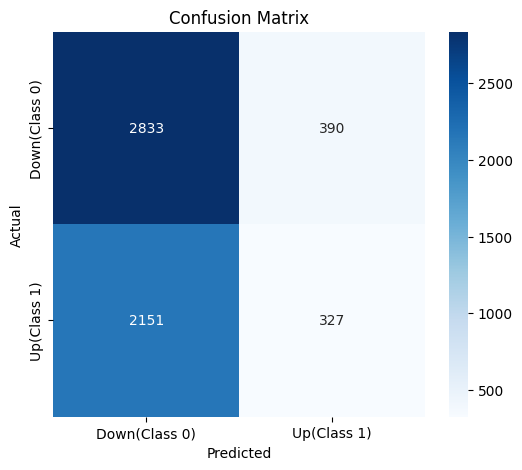

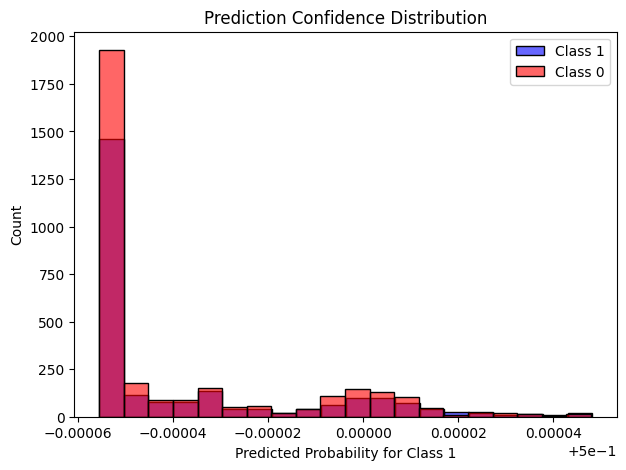

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Testing
model.eval()
all_predictions = []
true_labels = []
all_probs = [] 

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        
        probs = torch.softmax(outputs, dim=1) 
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  

true_labels = np.array(true_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

print(f"Accuracy: {accuracy_score(true_labels, all_predictions):.4f}")
print(classification_report(true_labels, all_predictions, zero_division=0))

conf_matrix = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(7, 5))
sns.histplot(all_probs[true_labels == 1], color="blue", label="Class 1", bins=20, alpha=0.6)
sns.histplot(all_probs[true_labels == 0], color="red", label="Class 0", bins=20, alpha=0.6)
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()


Backtest Metrics for DeepLOB Strategy:
Final Capital: 1002.41
Annualized Return: 83.36%
Annualized Volatility: 0.00%


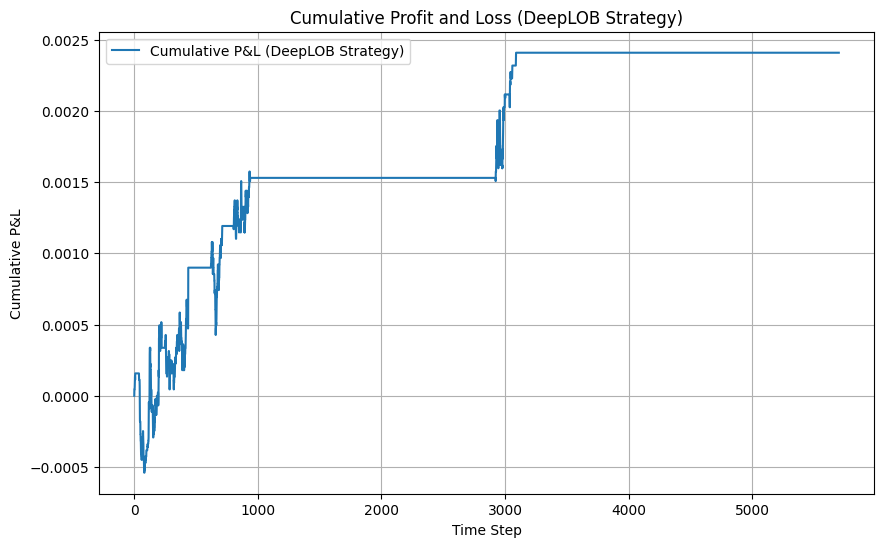

In [88]:
from finance_utils import plot_backtest_results, backtest_strategy

# Extract true percentage changes from the dataset
true_percentage_changes = test_df["mid_price_variation"].iloc[look_back:].values
timestamps = test_df.index[look_back:]

lstm_results = backtest_strategy(
    all_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(lstm_results, "DeepLOB Strategy")